In [1]:
import os
import sys
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

import functions as f

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
patient_info = pd.read_csv('ADNI_full/patient_info.csv')
# Creating the diagnostic_label.csv, age.csv and sex.csv files from the patient_info.csv file
def extract_info_and_write_csv(patient_info_file):
    patient_info_df = pd.read_csv(patient_info_file)
    age_df = patient_info_df[['Age']]
    age_df.to_csv('ADNI_full/age.csv', index=False, header=False)
    sex_df = patient_info_df[['Sex']]
    sex_df.to_csv('ADNI_full/sex.csv', index=False, header=False)
    diagnostic_label_df = patient_info_df[['Research Group']]
    diagnostic_label_df.to_csv('ADNI_full/diagnostic_label.csv', index=False, header=False)
extract_info_and_write_csv('ADNI_full/patient_info.csv')

Looking into the brain data

In [3]:
# Generating the brain atlas
def gen_atlas_labels():
    atlas = datasets.fetch_atlas_aal()
    atlas_filename = atlas.maps
    atlas_labels = atlas.labels
    n_ROIS = len(atlas_labels)
    return atlas, atlas_filename, atlas_labels, n_ROIS

atlas, atlas_filename, labels, n_ROIS = gen_atlas_labels()
print(type(atlas), type(atlas_filename), type(labels), type(n_ROIS))

# Finding the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

# Making a dictionary out of the positions of the brain segments and the positions in MNI space
brain_segments_pos = {}
for idx, val in enumerate(atlas.labels):
    brain_segments_pos[val] = list(np.around(coordinates[idx],2))

<class 'sklearn.utils._bunch.Bunch'> <class 'str'> <class 'list'> <class 'int'>


Brain segment positions in MNI space:
Precentral_L: [-38.93, -6.96, 49.65]
Precentral_R: [41.1, -9.55, 50.81]
Frontal_Sup_L: [-18.8, 33.42, 40.99]
Frontal_Sup_R: [21.6, 29.91, 42.51]
Frontal_Sup_Orb_L: [-16.82, 45.92, -14.72]
Frontal_Sup_Orb_R: [18.18, 46.62, -15.49]
Frontal_Mid_L: [-33.76, 31.5, 34.13]
Frontal_Mid_R: [37.4, 31.77, 32.8]
Frontal_Mid_Orb_L: [-30.89, 49.14, -10.99]
Frontal_Mid_Orb_R: [32.89, 51.27, -12.14]
Frontal_Inf_Oper_L: [-48.8, 11.49, 17.8]
Frontal_Inf_Oper_R: [49.93, 13.68, 20.2]
Frontal_Inf_Tri_L: [-45.89, 28.67, 12.58]
Frontal_Inf_Tri_R: [50.06, 28.9, 12.82]
Frontal_Inf_Orb_L: [-36.24, 29.49, -13.46]
Frontal_Inf_Orb_R: [40.91, 30.99, -13.26]
Rolandic_Oper_L: [-47.38, -9.75, 12.64]
Rolandic_Oper_R: [52.38, -7.54, 13.33]
Supp_Motor_Area_L: [-6.81, 3.13, 60.54]
Supp_Motor_Area_R: [8.25, -1.09, 60.51]
Olfactory_L: [-8.9, 13.93, -13.01]
Olfactory_R: [10.12, 14.66, -12.56]
Frontal_Sup_Medial_L: [-6.82, 48.23, 28.81]
Frontal_Sup_Medial_R: [8.75, 49.53, 28.93]
Frontal_M

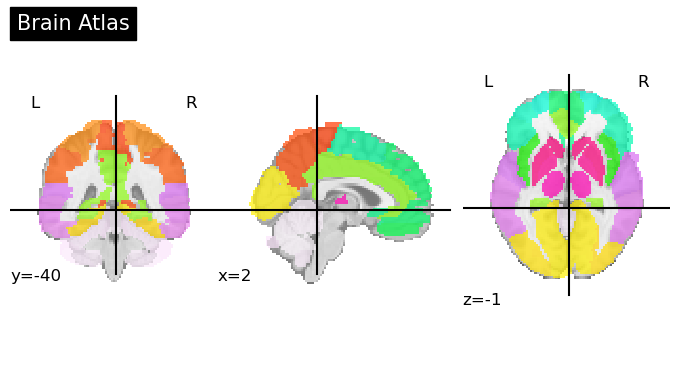

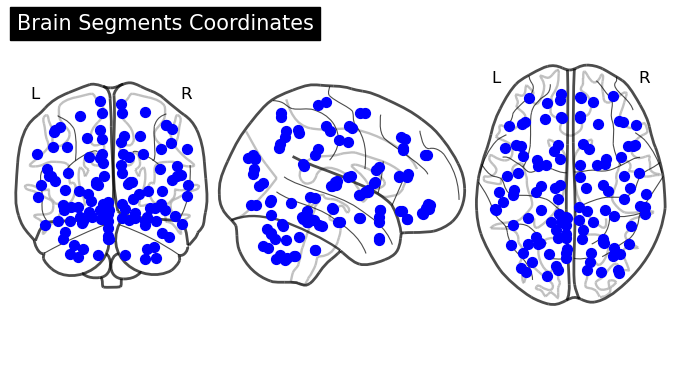

In [4]:
# Print the dictionary of brain segment positions
print("Brain segment positions in MNI space:")
for label, pos in brain_segments_pos.items():
    print(f"{label}: {pos}")
print(len(brain_segments_pos))

# Convert brain_segments_pos dictionary to an array of coordinates
node_coords = np.array(list(brain_segments_pos.values()))

# Visualize the brain atlas and its coordinates
plotting.plot_roi(atlas_filename, title='Brain Atlas')
plotting.plot_connectome(np.zeros((n_ROIS, n_ROIS)), node_coords,
                         node_color='b', title='Brain Segments Coordinates')

In [5]:
# Here I start with the ADNI_full folder with the time_series folder already generated, so I only need to load the time series
def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = os.listdir(root)
    time_series=[]
    for i in time_series_list:
        time_series_sub = np.loadtxt(os.path.join(root, i), delimiter=',')
        time_series.append(time_series_sub)
    return time_series

In [6]:
time_series_list = load_time_series()
# time_series_list[0].shape
print(time_series_list[0])
print('Number of regions (columns):', len(time_series_list[0][0]))

[[ 0.2642692   0.16040181  0.57371396 ...  0.12500933  0.10330407
   0.87038028]
 [ 0.19085962  0.2113862  -0.33421484 ... -0.578403   -0.93550503
  -2.03994942]
 [ 0.72830963  0.59393024  0.08317391 ... -1.05355597 -1.09166551
  -2.44226503]
 ...
 [-0.55627531 -0.6736297   0.30549684 ... -0.31409562  0.13894109
   1.10015774]
 [-0.0594647  -0.80384517  0.75589734 ...  0.27089831  0.33234671
   1.13989151]
 [ 0.09926764  0.10549345  0.25314325 ... -0.04953214 -0.06472567
   0.06441833]]
Number of regions (columns): 116


In [7]:
# Make the list of time series into a list of df
def list_of_df_of_time_series(time_series_list):
    time_series_df_list = []
    for ts in time_series_list:
        df = pd.DataFrame(ts)
        time_series_df_list.append(df)
    return time_series_df_list

In [8]:
time_series_df_list = list_of_df_of_time_series(time_series_list)
time_series_df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,0.264269,0.160402,0.573714,-0.016659,0.147470,0.327784,0.563114,-0.070485,-0.120396,0.258554,...,0.957419,1.334523,1.962177,0.217791,-0.462089,-0.964584,0.139684,0.125009,0.103304,0.870380
1,0.190860,0.211386,-0.334215,0.574008,-0.535597,-0.334685,0.021171,-0.062069,-0.619519,-0.417604,...,-1.813221,-0.202942,-3.085048,-0.824117,0.126268,0.982404,-0.056039,-0.578403,-0.935505,-2.039949
2,0.728310,0.593930,0.083174,0.961234,-0.744761,-0.343953,0.225210,0.192818,-0.765734,-0.846390,...,-2.118421,-1.320937,-3.443132,-0.496449,0.048864,1.031379,-0.622402,-1.053556,-1.091666,-2.442265
3,1.173054,0.813959,0.850006,0.986218,-0.296675,-0.042714,0.487224,0.657435,-0.623107,-0.809165,...,-0.356367,-1.495009,-0.637532,0.484914,-0.155445,0.063728,-0.694769,-0.650007,-0.214159,-0.715906
4,0.520118,0.189850,0.294528,0.572696,0.235907,-0.238069,-0.158185,0.916665,-0.472160,-0.386730,...,1.051838,-0.867597,0.830351,0.510131,0.291727,0.084524,0.454218,0.673080,0.886583,0.653972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,-1.887287,-0.764243,-2.184397,-0.703209,-0.268133,0.508347,-1.634119,-0.079656,0.088563,-0.193855,...,-0.806249,-1.130631,1.380863,2.626379,1.571630,1.059438,0.094542,-0.402776,-0.310997,0.092674
135,-1.408172,-0.359410,-1.143153,0.383183,0.688927,0.152477,-0.765884,0.836259,1.406583,0.973454,...,-1.051386,-1.318953,-0.254829,-0.240125,-0.179914,-0.150726,-1.168134,-0.838199,-0.244921,0.450691
136,-0.556275,-0.673630,0.305497,0.371132,1.935064,0.062150,0.366279,0.592698,2.608838,1.816980,...,-0.127304,0.130361,-1.071571,-2.299211,-1.188028,-0.992597,-1.128509,-0.314096,0.138941,1.100158
137,-0.059465,-0.803845,0.755897,0.056427,1.975473,0.260254,0.696158,0.131610,2.123145,1.474213,...,0.605091,1.033485,-0.620795,-1.921884,-0.981408,-0.837469,-0.304420,0.270898,0.332347,1.139892


In [9]:
print(len(time_series_list))
print(len(time_series_list[0]))
print(len(time_series_list[0][0]))

197
139
116


Let's now only keep the most interesting/affected regions for Alzheimer's.
Those regions are the Hippocampus, Entorhinal cortex, Cingulate gyrus, Motor Cortex, Sensory Cortex, and Cerebellum.

In [10]:
# Index in the atlas of the concerned regions

indexes = [
    # Hippocampus
    40, 41,
    # Entorhinal Cortex
    42, 43,
    # Cingulate Gyrus
    30, 31, 32, 33, 34, 35,
    # Motor Cortex
    0, 1,
    # Sensory Cortex
    62, 63,
    # Cerebellum
    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115
]

# Sorting the list of indexes
indexes.sort()

# Extract the time series of the concerned regions
selected_time_series_data = []
for i in range(len(time_series_list)):
    # print(time_series_list[i][:, indexes])
    selected_time_series_data.append(time_series_list[i][:, indexes])

print(len(selected_time_series_data))
print(len(selected_time_series_data[0]))
print(len(selected_time_series_data[0][0]))

197
139
40


In [11]:
# Making a df again
selected_time_series_df = list_of_df_of_time_series(selected_time_series_data)

Brain segment positions in MNI space:
Precentral_L: [-38.93, -6.96, 49.65]
Precentral_R: [41.1, -9.55, 50.81]
Frontal_Sup_L: [-18.8, 33.42, 40.99]
Frontal_Sup_R: [21.6, 29.91, 42.51]
Frontal_Sup_Orb_L: [-16.82, 45.92, -14.72]
Frontal_Sup_Orb_R: [18.18, 46.62, -15.49]
Frontal_Mid_L: [-33.76, 31.5, 34.13]
Frontal_Mid_R: [37.4, 31.77, 32.8]
Frontal_Mid_Orb_L: [-30.89, 49.14, -10.99]
Frontal_Mid_Orb_R: [32.89, 51.27, -12.14]
Frontal_Inf_Oper_L: [-48.8, 11.49, 17.8]
Frontal_Inf_Oper_R: [49.93, 13.68, 20.2]
Frontal_Inf_Tri_L: [-45.89, 28.67, 12.58]
Frontal_Inf_Tri_R: [50.06, 28.9, 12.82]
Frontal_Inf_Orb_L: [-36.24, 29.49, -13.46]
Frontal_Inf_Orb_R: [40.91, 30.99, -13.26]
Rolandic_Oper_L: [-47.38, -9.75, 12.64]
Rolandic_Oper_R: [52.38, -7.54, 13.33]
Supp_Motor_Area_L: [-6.81, 3.13, 60.54]
Supp_Motor_Area_R: [8.25, -1.09, 60.51]
Olfactory_L: [-8.9, 13.93, -13.01]
Olfactory_R: [10.12, 14.66, -12.56]
Frontal_Sup_Medial_L: [-6.82, 48.23, 28.81]
Frontal_Sup_Medial_R: [8.75, 49.53, 28.93]
Frontal_M

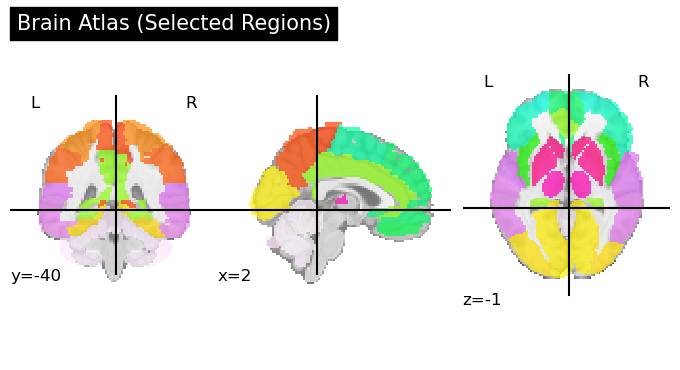

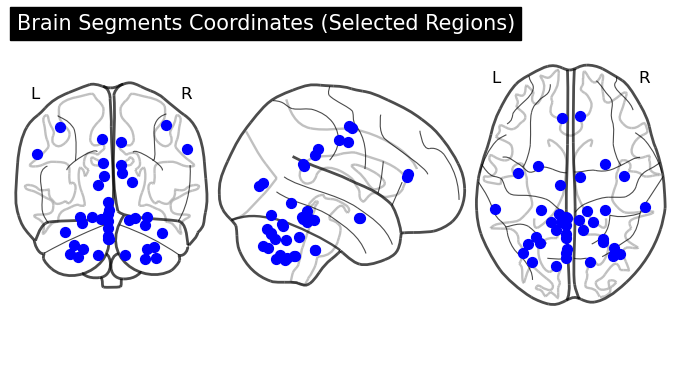

In [12]:
# Display of new selected regions

indexes = [
    40, 41, 42, 43, 30, 31, 32, 33, 34, 35,
    0, 1, 62, 63, 90, 91, 92, 93, 94, 95,
    96, 97, 98, 99, 100, 101, 102, 103, 104, 105,
    106, 107, 108, 109, 110, 111, 112, 113, 114, 115
]

print("Brain segment positions in MNI space:")
for label, pos in brain_segments_pos.items():
    print(f"{label}: {pos}")
print(len(brain_segments_pos))

node_coords = np.array(list(brain_segments_pos.values()))
selected_node_coords = node_coords[indexes]
selected_connectome = np.zeros((len(indexes), len(indexes)))

plotting.plot_roi(atlas_filename, title='Brain Atlas (Selected Regions)')
plotting.plot_connectome(selected_connectome, selected_node_coords,
                         node_color='b', title='Brain Segments Coordinates (Selected Regions)')

In [28]:
# Defining the different correlation relations to build the correlation matrix.
# We also set the NaN values to 0.

def pearson_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='pearson').fillna(0)
        np.fill_diagonal(corr_df.values, 1)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def spearman_rank_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='spearman').fillna(0)
        np.fill_diagonal(corr_df.values, 1)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def kendall_rank_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='kendall').fillna(0)
        np.fill_diagonal(corr_df.values, 1)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def partial_corr(time_series_df_list):
    corr_matrices = []
    for df in time_series_df_list:
        corr_df = df.corr(method='pearson').fillna(0)
        np.fill_diagonal(corr_df.values, 1)
        n = corr_df.shape[0]
        partial_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])
        corr_matrices.append(partial_corr_matrix)
    return corr_matrices

In [29]:
# Plot the correlation matrix
def plot_corr(corr_matrix, method):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'{method} Correlation Matrix')
    plt.show()

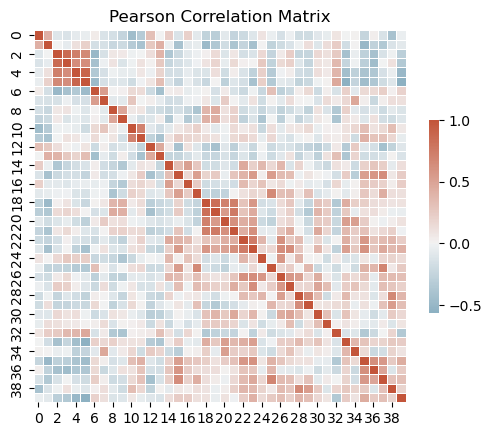

In [31]:
# Generating the correlation matrices with only the selected regions
idx_patient = 20

# Using the pearson correlation function (we will use only this one for the rest of the notebook)
corr_matrix_pearson = pearson_corr(selected_time_series_df)
plot_corr(corr_matrix_pearson[idx_patient], 'Pearson')

In [32]:
# Compare the differences between all the matrices. Here I am using the Frobenius norm to measure the element-wise differences.

matrices = [corr_matrix_pearson[idx_patient]]

def compare_correlation_matrices(matrices):
    num_matrices = len(matrices)
    dissimilarities = np.zeros((num_matrices, num_matrices))
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            diff_matrix = matrices[i] - matrices[j]
            frobenius_norm = np.linalg.norm(diff_matrix, ord='fro')
            dissimilarities[i, j] = frobenius_norm
            dissimilarities[j, i] = frobenius_norm
    return dissimilarities

# Compare matrices
dissimilarities = compare_correlation_matrices(matrices)
print("Dissimilarities between correlation matrices:")
print(dissimilarities)

Dissimilarities between correlation matrices:
[[0.]]


In [36]:
# Savingthe pearson Correlation Matrices for the selected regions
def save_corr_matrix(corr_matrix, method):
    directory = f'ADNI_full/corr_matrices_selected_regions/corr_matrix_{method}/'
    patient_info = pd.read_csv('ADNI_full/patient_info.csv')
    os.makedirs(directory, exist_ok=True)
    for idx_patient, name_patient in enumerate(patient_info['Subject ID'].values):
        np.savetxt(f'{directory}patient_{name_patient}.csv', corr_matrix[idx_patient], delimiter=',')
    return None

save_corr_matrix(corr_matrix_pearson, 'pearson')

In [34]:
# Creating a dictionnary with the time series, the correlation matrices and the diagnostic label for each patient
def create_dict(patient_info, corr_matrices, time_series_list):
    full_data_dict = {}
    for i, patient_id in enumerate(patient_info['Subject ID'].values):
        age = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Age'].values[0]
        sex = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Sex'].values[0]
        diagnostic_label = patient_info.loc[patient_info['Subject ID'] == patient_id, 'Research Group'].values[0]
        corr_matrices_patient = []
        for method in corr_matrices:
            corr_matrix = method[i]
            corr_matrices_patient.append(corr_matrix)
            # print('len(corr_matrices_patient)', len(corr_matrices_patient))
            # print('len(corr_matrix)', len(corr_matrix))
        patient_data = [age, sex, diagnostic_label] + corr_matrices_patient + [time_series_list[i]]
        # print(len(patient_data))
        full_data_dict[patient_id] = patient_data
    print(full_data_dict[patient_id])
    return full_data_dict

corr_matrices = [corr_matrix_pearson]
full_data_dict = create_dict(patient_info, corr_matrices, time_series_list)
# Saving the dictionary to a pickle file
with open('ADNI_full/full_data_dict.pkl', 'wb') as f:
    pkl.dump(full_data_dict, f)

[71.9, 'F', 'AD', array([[ 1.        ,  0.49708192, -0.30196653, ...,  0.0491811 ,
        -0.04241718,  0.06618051],
       [ 0.49708192,  1.        , -0.06294033, ..., -0.03631092,
        -0.05914186, -0.14650639],
       [-0.30196653, -0.06294033,  1.        , ...,  0.18490918,
        -0.09555616,  0.12560314],
       ...,
       [ 0.0491811 , -0.03631092,  0.18490918, ...,  1.        ,
         0.51429201,  0.22375305],
       [-0.04241718, -0.05914186, -0.09555616, ...,  0.51429201,
         1.        ,  0.28715004],
       [ 0.06618051, -0.14650639,  0.12560314, ...,  0.22375305,
         0.28715004,  1.        ]]), array([[-0.04346184,  0.96485059,  0.41196631, ..., -0.88567501,
        -1.26428183, -0.37358799],
       [ 1.03229898, -0.27778755,  0.12742696, ...,  1.9399993 ,
         1.60648668,  1.52536428],
       [-0.11437896, -1.01827799, -0.1114998 , ...,  1.09472796,
         1.54447804,  1.00860942],
       ...,
       [-0.57405979, -0.23233426, -1.38614436, ..., -0.2

In [35]:
full_data_dict = pkl.load(open('ADNI_full/full_data_dict.pkl', 'rb'))